# Simulate Asset Price Evolutions and Reprice Risky up-and-out Call Option

Group 6-A 

Members:

1. Md. Shafil Hosain (shafil430@yahoo.com)

2. Si Jie Lim (limsijie93@gmail.com)

3. Quang Vinh Dang (dqvinh87@gmail.com)

4. Wei Hao Lew (lewweihao93@hotmail.com)

5. Philip ZF Chen (philipchen619@gmail.com)

# Question 1

In this project, we will be pricing an up-and-out call option, but this time with stochastic interest rate and non-constant volatility, using Monte Carlo simulation. We will be using LFMM to model interest rates and CEV to model volatility.

First, we import the necessary libraries needed for the code.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import functools
import math

Next, we define the list of parameter values needed.

In [2]:
L = 150                 #barrier limit
S_0 = 100               #starting share value
K = 100                 #strike price
V_0 = 200               #starting firm value
D = 175
gamma = 0.75
debt = 175              #firm debt
sigma_s = 0.30          #share volatility
sigma_v = 0.30          #firm value volatility
correlation = 0.2       #correlation between share and firm
recovery_rate = 0.25    #firm recovery rate
n_simulations = 100000
dt = 1/12               #expiry time of option / monthly simulations for a year
frequency = 12          #monthly simulations for a year
T = 1                   #expiry time of option

## Calibration

We are first going to calibrate the LFMM using the observed zero coupon bond prices. 

The jth forward rate at time t can be defined as

$F_j(t) = \frac{P_j(t)-P_{j+1}(t)}{\delta_t P_{j+1}(t)}$

We are going to use this formula to calibrate and obtain the initial forward rates, which will be used to simulate future rates as in the LFMM model.

In [3]:
def bondPricesToInitialForwardRates(bond_prices, n_steps):
    return np.ones([n_simulations, n_steps - 1]) * (bond_prices[:-1] - bond_prices[1:])/(dt * bond_prices[1:])

In [4]:
bond_prices = np.array([100, 99.38, 98.76, 98.15, 97.54, 96.94, 96.34, 95.74, 95.16, 94.57, 93.99, 93.42, 92.85])
n_steps = len(bond_prices) 

forward_rates = bondPricesToInitialForwardRates(bond_prices, n_steps)

## Interest Rate - LIBOR Forward Market Model (LFMM)

The LFMM says that the forward rate evolves according to the following formula

$F_j(t_i) = F_j(t_{i-1})exp[(\mu_j(t_{i-1})-\frac{1}{2}\sigma^2)\delta_{i-1} + \sigma_j\sqrt{\delta_{i-1}}Z_i]$

where

$\mu_j(t_{i-1}) \ \sum_{k=i}^j \frac{\delta_k F_j(t_{i-1})\sigma_k\sigma_j}{1+\delta_kF_j(t_{i-1})}$

which can be written as

In [5]:
def getMu(forward_rates, delta, sigma_j, sigma_k):
    return np.cumsum(delta * forward_rates * sigma_j * sigma_k/(1 + delta * forward_rates), axis=1)

def getInitialNextForwardEstimate(forward_rates, mu, sigma, delta, Z):
    return forward_rates * np.exp((mu - (sigma**2)/2) * delta + sigma * np.sqrt(delta) * Z)


However, to improve the accuracy, we will use the Predictor-Corrector method which involves estimating the next period's drift and then taking the average. Hence, the final estimate of the forward rate is given by:

$F_j(t_i) = F_j(t_{i-1})exp[\frac{1}{2}(\mu_j(t_{i-1})+\mu_j(t_i)-\sigma^2)\delta_{i-1} + \sigma_j\sqrt{\delta_{i-1}}Z_i]$

This final estimate is written as:

In [6]:
def getFinalNextForward(forward_rates, mu1, mu2, sigma, delta, Z):
    return forward_rates * np.exp(0.5 * (mu1 + mu2 - sigma**2) * delta + sigma * np.sqrt(delta) * Z)

Furthermore, the continuously compounded interest rate can be derived from the LIBOR forward rate as follows:

$e^{r_{ti}(t_{i+1}-t_i)} = 1 + L(t_i, t_{i+1})(t_{i+1} - t_i)$

In [7]:
def liborToContinuousRate(libor, dt):
    return 1 + (libor * dt)

## Volatility - CEV Model

We will be using the CEV model to represent volatility, which is given by

$\sigma(t_i, t_{i+1}) = \sigma(S_{it})^{\gamma-1}$

In [8]:
def getVolatility(S_t, gamma, sigma):
    return sigma * S_t**(gamma - 1)

## Stock Price Model

We assume the following lognormal evolution of stock price/firm value:

$S_{t_{i+1}} = S_{t_i}exp[(r - \frac{\sigma^2(t_i, t_{i+1})}{2})(t_{i+1}-t_i)+\sigma(t_i, t_{i+1})\sqrt{t_{i+1}-t_i}Z]$

which can be re-written as

$S_{t_{i+1}} = S_{t_i}exp[r(t_{i+1}-t_i)]exp[(- \frac{\sigma^2(t_i, t_{i+1})}{2})(t_{i+1}-t_i)+\sigma(t_i, t_{i+1})\sqrt{t_{i+1}-t_i}Z]$

In [9]:
def getSharePrice(S_t, continuous_rate, sigma, dt, Z):
    return S_t * continuous_rate * np.exp(-sigma**2/2 * dt + sigma * np.sqrt(dt) * Z)

## Simulation

First, we initialise the stock matrix and delta matrix.

In [10]:
delta = np.ones([n_simulations, n_steps - 1]) * dt
stock = np.ones([n_simulations, n_steps]) * S_0
firm = np.ones([n_simulations, n_steps]) * V_0
continuousRates = np.ones([n_simulations, n_steps - 1])

volatilities_s, volatilities_v = [], []

We also need to define a method to reshape our data structure

In [11]:
def reshape(input):
    return np.array([input, ]).transpose()

Then, we go to the actual simulation.

Simulating for 100000 simulations
Volatility at time 1: [0.09486833]
Forward Rates at time 1: [0.0812562  0.08292276 0.0869095  0.09062654 0.08402465 0.09453245
 0.09342372 0.09031738 0.09137199 0.09109857 0.09168773 0.0960269 ]
First LIBOR rate at time 1: 0.08125619771093102
Continuous rate at time 1: [1.00677135]
Stock Price at time 1: [99.80861544]
Firm Value at time 1: [198.81775683]


Volatility at time 2: [0.09491378]
Forward Rates at time 2: [0.0835401  0.087557   0.09130225 0.08465158 0.09523834 0.09412188
 0.09099284 0.09205587 0.09178091 0.09237502 0.0967473 ]
First LIBOR rate at time 2: 0.08354010400920395
Continuous rate at time 2: [1.00696168]
Stock Price at time 2: [103.39735765]
Firm Value at time 2: [205.29995272]


Volatility at time 3: [0.09407926]
Forward Rates at time 3: [0.08978754 0.09362873 0.08680905 0.0976662  0.09652185 0.09331354
 0.09440421 0.09412278 0.09473259 0.09921705]
First LIBOR rate at time 3: 0.0897875412096778
Continuous rate at time 3: [1.0074823]

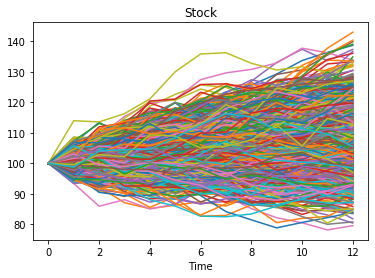

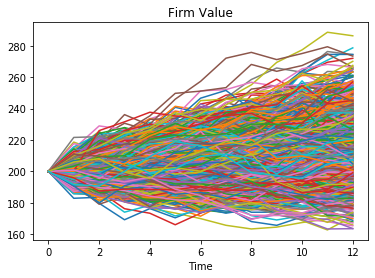

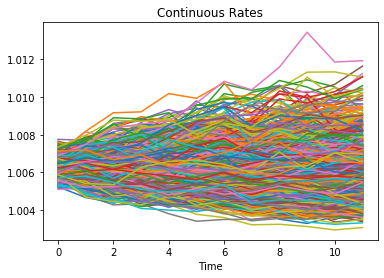

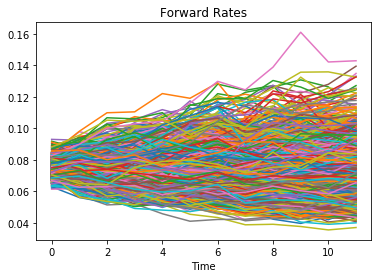

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:
print("Simulating for {} simulations".format(n_simulations))

for i in range(0, 12):
    #each iteration is a point in time, estimating for 12 forward rates
    forward_Z = norm.rvs(size = [n_simulations, 1])
    stock_Z = norm.rvs(size = [n_simulations, 1])
    firm_Z = norm.rvs(size = [n_simulations, 1])
    
    S_t_minus_one = stock[:, i]
    V_t_minus_one = firm[:, i]
    forward_rates_t = forward_rates[:, i:]
    delta_t = delta[:, i:]
    
    sigma_v_new = getVolatility(V_t_minus_one, gamma, sigma_v)
    volatilities_v.append(sigma_v_new)

    sigma_s_new = getVolatility(S_t_minus_one, gamma, sigma_s)
    volatilities_s.append(sigma_s_new)

    #duplicate the sigma across more columns as the same sigma will be used to calculate the other forward rates 
    sigma_s_new_transposed = np.array([sigma_s_new,] * (n_steps - (i + 1))).transpose() 
    
    mu_initial = getMu(forward_rates_t, delta_t, sigma_s_new_transposed, sigma_s_new_transposed)
    forward_temp = getInitialNextForwardEstimate(forward_rates_t, mu_initial, sigma_s_new_transposed, delta_t, forward_Z)
    mu_next = getMu(forward_temp, delta_t, sigma_s_new_transposed, sigma_s_new_transposed)
    final_forwards = getFinalNextForward(forward_rates_t, mu_initial, mu_next, sigma_s_new_transposed, delta_t, forward_Z)
    forward_rates[:,i:] = final_forwards
    
    first_libor_rate = forward_rates[:,i]
    continuous_rate = liborToContinuousRate(first_libor_rate, dt)
    continuous_rate = reshape(continuous_rate)
    continuousRates[:, i] = continuous_rate[:,0]
    
    sigma_s_new = reshape(sigma_s_new)
    S_t_minus_one = reshape(S_t_minus_one)
    V_t_minus_one = reshape(V_t_minus_one)
    S_t = getSharePrice(S_t_minus_one, continuous_rate, sigma_s_new, dt, stock_Z)
    V_t = getSharePrice(V_t_minus_one, continuous_rate, sigma_s_new, dt, firm_Z)
    stock[:, i + 1] = S_t[:,0]
    firm[:, i + 1] = V_t[:,0]
    
    print("Volatility at time " + str(i+1) + ": " + str(sigma_s_new[0]))
    print("Forward Rates at time " + str(i+1) + ": " + str(final_forwards[0]))
    print("First LIBOR rate at time " + str(i+1) + ": " + str(first_libor_rate[0]))
    print("Continuous rate at time " + str(i+1) + ": " + str(continuous_rate[0]))
    print("Stock Price at time " + str(i+1) + ": " + str(S_t[0]))
    print("Firm Value at time " + str(i+1) + ": " + str(V_t[0]))
    print("\n")
    
for i in range(0, 1000):
    plt.title("Stock")
    plt.xlabel("Time")
    plt.plot(stock[i, :])
    
plt.show()
plt.figure()

for i in range(0, 1000):
    plt.title("Firm Value")
    plt.xlabel("Time")
    plt.plot(firm[i, :])
    
plt.show()
plt.figure()

for i in range(0, 1000):
    plt.title("Forward LIBOR Rates")
    plt.xlabel("Time")
    plt.plot(forward_rates[i, :])
    
plt.show()
plt.figure()

for i in range(0, 1000):
    plt.title("Continuous Rates")
    plt.xlabel("Time")
    plt.plot(continuousRates[i, :])
    
plt.show()
plt.figure()

Due to the large sample size, we only show up to 1000 paths.

# Question 2

According to the question, the share price evolves according to the following recursive formula

$S_{t_{i+1}} = S_{t_i} e^{r-\frac{\sigma^2 (t_i,t_{i+1})}{2}(t_{i+1}-t_i)+\sigma(t_i, t_{i+1})\sqrt{t_{i+1}-t_i}Z}$

and the local volatility functions follow the following formula

$\sigma_s(t_i,t_{i+1}) = \sigma(S_{ti})^{\gamma-1}$
and
$\sigma_v(t_i,t_{i+1}) = \sigma(V_{ti})^{\gamma-1}$

where ${\gamma}$ = 0.75 and $\sigma$ = 0.3

In [13]:
def european_call_payoff(S_T, K, r):
    """
    This function takes in the following parameters to determine the price of the European call option:
      S_T is the price of the underlying at expiry.
      K is the strike price
      r is the discount rate 
    """
    return r * np.maximum(0, S_T - K) #payoff for call option

def euro_uao_call(barrier, paths, K, discount_factors):
    """
    This functions takes in the following parameters to calculate the value of a European Up-And-Out call option:
      barrier is the barrier level,
      paths is a list of share price paths,
      K is the strike price
      r is the discount rate 
    """
    prices = []
    for i in range(0, len(paths)):
            path = paths[i]
            discount_factor = discount_factors[i]
    
            if np.max(path) > barrier: # knocked out
                    prices.append(0)
            else:
                    payoff = european_call_payoff(path[-1], K, discount_factor)
                    prices.append(payoff)
    return np.mean(prices)

In [14]:
# We will now calculate the value of the option with no default risk and with counterparty default risk using values calculated in part 1

# Using the simulated interest rates from LFMM, we calculate the corresponding interest rate at time t = 0
one_year_rates = np.prod(continuousRates, axis=1)
one_year_discount_factors = np.reciprocal(one_year_rates)

# Calculate the European up-and-out call option value 
call_val = euro_uao_call(L, stock, K, one_year_discount_factors)

#Get the terminal firm value
term_firm = firm[:, -1]

# CVA: 
# To calculate the amount lost, we apply the formula [np.exp(-T/frequency*r) * (1-recovery_rate)*(term_firm_val < debt) * call_val] for each simulated terminal firm value in the monte carlo simulation. 
amount_lost = [one_year_discount_factors * (1-recovery_rate)*(term_firm < debt) * call_val]
cva = np.mean(amount_lost)

# Calculate the adjusted value for the European up-and-out call option
adjusted_opt_val = call_val - cva

The 1 year compounded rate is given by the following formula

$ e^{rT} = \prod_{i=1}^{12} e^{r_i(t_{i+1}-t_i)} $

This can then be converted to the 1-year discounted factor by:

$e^{-rT} = \frac{1}{e^{rT}}$

After which, Monte carlo simulation is performed over the 100000 simulated paths, using the simulated 1 year discount factor to discount the payoffs. The average of these discounted payoffs gives us the barrier option value.

This barrier option value is then run through again with the 100000 simulated terminal firm values and discount factors to arrive at a list of amount loss, the average of which gives us the CVA. This cva is subtracted from the previous call value to obtain an adjusted call value.

In [15]:
# Print values for simulation

print("Number of simulations: {}".format(n_simulations))
print("Average One-year discount factor based on LFMM: {}".format(np.mean(one_year_discount_factors)))

print('\n')

print("The mean value of the call option with no default risk based on {} simulations is {}".format(n_simulations, np.mean(call_val)))
print("The mean value of the CVA based on {} simulations is {}".format(n_simulations, cva))
print("The mean adjusted value of the  call option based on {} simulations is {}".format(n_simulations, adjusted_opt_val))

Number of simulations: 100000
Average One-year discount factor based on LFMM: 0.9285022091201268


The mean value of the call option with no default risk based on 100000 simulations is 8.287943447517996
The mean value of the CVA based on 100000 simulations is 0.09175937356085238
The mean adjusted value of the  call option based on 100000 simulations is 8.196184073957143



# References

1. 